In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import yt
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [52]:
from yt.visualization.api import Streamlines
from yt.visualization.volume_rendering.api import Scene, VolumeSource, LineSource, PointSource
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

In [4]:
import readfunctions as rf
import lmasources as ls
from coordinateSystems import GeographicSystem, MapProjection

In [5]:
geo   = GeographicSystem()

## Read in radar analysis

#### And pulling out the radar grid points for plotting later

In [166]:
filename = '/localdata/wind_analysis/sr12noxp_tdvar_2351_var.out'

dataf       = rf.outfile(filename)
r,u,v,w     = dataf.read_data() # These are in z,y,x
lon,lat,alt = dataf.latlon(geo)

rx,ry,rz = dataf.data_grid()
rx       = rx.reshape(np.shape(w))
ry       = ry.reshape(np.shape(w))
rz       = rz.reshape(np.shape(w))

## Corresponding LMA from .dat file

Analysis is at the time listed, every 3 min, so pulling source points for the following 3 minutes

In [167]:
lma_directory = '/home/vanna.chmielewski/analyzedlightning/notgz/'
lma_file = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,dataf.time[:3])
lmad = ls.lmafile(lma_file).readfile()

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    lma_file2 = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,sfi.strftime('%H%M')[:3])
    lmad2 = ls.lmafile(lma_file2).readfile()
    lmad = pd.concat((lmad,lmad2))

Setting limits for selection from the following 3 min and setting station minimum and chi squared maximum

In [168]:
tstart = int(dataf.time[:2])*3600 + int(dataf.time[2:])*60
tend   = tstart + 3*60
mxchi  = 1.0
mnnum  = 7.0

sources = lmad[(lmad['time'] >= tstart)  & (lmad['time'] < tend) & 
               (lmad['chi']  <= mxchi)   & (lmad['num'] >= mnnum)]
psource = sources[sources['charge'] ==  3]
nsource = sources[sources['charge'] == -3]

### Mapping and gridding corresponding to radar grid (in x,y,z)

Plot check for sanity

In [169]:
exs,eys,ezs = geo.toECEF(np.array(sources['lon']),
                         np.array(sources['lat']),
                         np.array(sources['alt']))
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
nxs,nys,nzs = projl.fromECEF(exs,eys,ezs)

In [170]:
binz = np.arange(dataf.iz,dataf.nz*dataf.dz+dataf.iz+dataf.dz,dataf.dz)-dataf.dz/2.
biny = np.arange(dataf.iy,dataf.ny*dataf.dy+dataf.iy+dataf.dy,dataf.dy)-dataf.dy/2.
binx = np.arange(dataf.ix,dataf.nx*dataf.dx+dataf.ix+dataf.dx,dataf.dx)-dataf.dx/2.

negs = sources['charge'] == -3
poss = sources['charge'] ==  3
unas = sources['charge'] ==  0
abins = (binx,biny,binz)

all_counts = np.histogramdd(np.array([nxs,nys,nzs]).T,bins=abins)[0]
p_counts   = np.histogramdd(np.array([nxs[poss],nys[poss],nzs[poss]]).T,bins=abins)[0]
n_counts   = np.histogramdd(np.array([nxs[negs],nys[negs],nzs[negs]]).T,bins=abins)[0]

## Read in flash-sorted grid files

In [171]:
flash_grid_dir = '/localdata/KingfisherAnalysis/flashsort/grid_files/2012/May/29/'

grid_var = {'flash_extent' : 'flash_extent',
            'flash_init' : 'flash_initiation',
            'flashsize_std' : 'flashsize_std',
            'footprint' : 'flash_footprint',
            'source' : 'lma_source',
            'specific_energy' : 'specific_energy',
            'total_energy' : 'total_energy',
           }

In [172]:
flashgrid = xr.Dataset()
for key in grid_var:
    filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,dataf.time[:3],key)
    flashgrid = xr.auto_combine((flashgrid,xr.open_dataset(filename)))

#
## This takes WAY too much memory. MUST be a better way
#

# if int(dataf.time[3]) > 7:
#     flashgrid2 = xr.Dataset()
#     sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
#     for key in grid_var:
#         filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,sfi.strftime('%H%M')[:3],key)
#         flashgrid2 = xr.auto_combine((flashgrid2,xr.open_dataset(filename)))
# #     flashgrid = xr.concat((flashgrid,flashgrid2),'ntimes',data_vars='minimal')

In [173]:
glo,gla,gal = np.meshgrid(np.array(flashgrid['longitude']),
                          np.array(flashgrid['latitude']),
                          np.array(flashgrid['altitude']))

gexs,geys,gezs = geo.toECEF(glo,gla,gal)
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
gnxs,gnys,gnzs = projl.fromECEF(gexs,geys,gezs)

### DLA analysis FORTRAN-array output text files

Same grid as radar analysis, trajectory files are on $\Delta$t by subsetted z,y,x

In [174]:
DLAvariables = ['obqrat','obqclw','obqxlw','obthet','obthetv',
                'obqrlw','obqslw','obqglw']

i = 0
DLA = np.zeros((8,35,122,182))
for vari in DLAvariables:
    testfile = '/localdata/DLA/output/{0}_gto_{1}.txt'.format(vari,dataf.time)
    test = pd.read_csv(testfile,header=None,delim_whitespace=True,na_values=-1000.0)
    DLA[i] = np.array(test).flatten()[:-57].reshape((35,122,182))
    i = i+1

# Matchin up different grids (y-cross section)

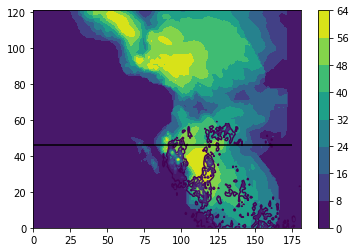

In [175]:
gridcell = 46
mfrom0 = gridcell*dataf.dx

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[5])
plt.hlines(mfrom0/dataf.dx,0,175)
plt.colorbar()

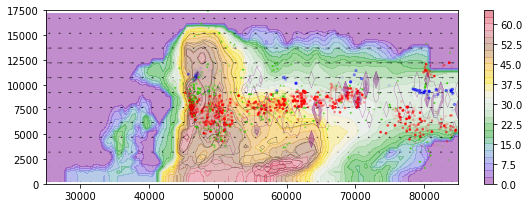

In [176]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)

rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

# plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],w[:,rgrid,:],levels=np.linspace(-20,20,10),cmap=pyart.graph.cm.NWSVel,alpha=0.5)
plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],30,cmap=pyart.graph.cm.Carbone11,alpha=0.5)
plt.colorbar()
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
           scale=2500, width=0.001, pivot='middle',
          )

plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],np.mean(flashgrid['flash_footprint'][8,:,lgrid-1:lgrid+2,:],axis=1),
            levels=np.arange(5,1500,50),colors='purple',linewidths=0.2)
plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

### Add in DLA trajectories

In [17]:
tx = pd.read_csv('/localdata/DLA/output/gridxt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)
ty = pd.read_csv('/localdata/DLA/output/gridyt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)
tz = pd.read_csv('/localdata/DLA/output/gridzt_gto_{0}.txt'.format(dataf.time),
                 header=None,delim_whitespace=True,na_values='-999.0',skiprows=1)

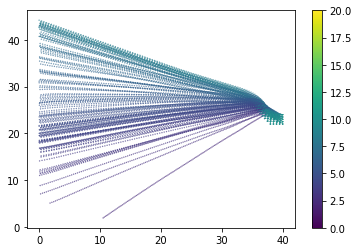

In [18]:
# selects = (tx[0]==85.) & (ty[0]==19) & (tz[0]==9.7)
buffer = 1.0
fx = 39.
fy = 23.
fz = 9.7
selects =   (tx[0]>=(fx-buffer)) & (tx[0]<=(fx+buffer)) & (ty[0]>=(fy-buffer)
        ) & (ty[0]<=(fy+buffer)) & (tz[0]<=(fz+buffer)) & (tz[0]>=(fz-buffer))

plt.scatter(tx.loc[selects],ty.loc[selects],c=tz.loc[selects], s=0.1)
plt.clim(0,20)
plt.colorbar()

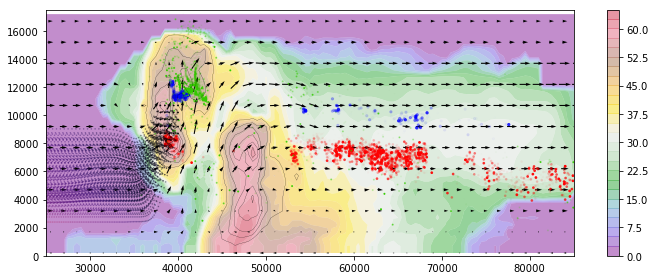

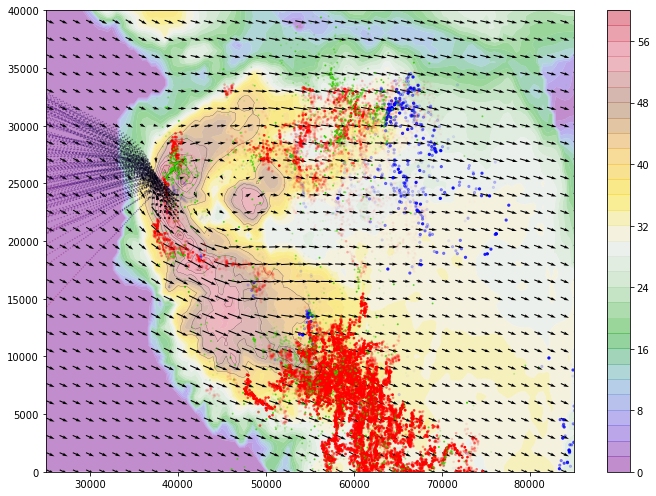

In [19]:
plt.figure(figsize=(10,4))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)
rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0)) # Just the closest cross section from flashgrid to the radar grid

plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],30,cmap=pyart.graph.cm.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
           scale=1500,width=0.002,pivot='middle',
          )

# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],np.mean(flashgrid['flash_footprint'][8,:,lgrid-1:lgrid+2,:],axis=1),
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.2)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.scatter(tx.loc[selects]*1e3,tz.loc[selects]*1e3,
            c=np.zeros_like(tx.loc[selects])+np.arange(151),s=0.2,cmap='magma',alpha=0.5)
#             c=np.abs(ty.loc[selects]*1e3-mfrom0),s=0.2,cmap='magma')

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

#########################################
plt.figure(figsize=(10,7))
level = 9.2

dist = np.abs(nzs-level*1e3)
alpha = np.exp(-dist/400.)
rgrid = int((level-0.2)*1e3/dataf.dy)
# lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

plt.contourf(rx[rgrid,:,:],ry[rgrid,:,:],r[rgrid,:,:],30,cmap=pyart.graph.cm.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
plt.contour(rx[rgrid,:,:],ry[rgrid,:,:],DLA[7,rgrid,:,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[rgrid,::step,::step],ry[rgrid,::step,::step],
            u[rgrid,::step,::step], v[rgrid,::step,::step],
           scale=1500,width=0.002,pivot='middle',
          )

# Note the flashgrid is 0.2 km off
# plt.contour(gnxs[:,:,rgrid//2],gnys[:,:,rgrid//2],np.mean(flashgrid['flash_footprint'][8,:,:,rgrid//2-1:rgrid//2+2],axis=2).T,
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.5)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nys[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nys[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nys[unas],color=c,edgecolors=c,s=1)

plt.scatter(tx.loc[selects]*1e3,ty.loc[selects]*1e3,
            c=np.zeros_like(tx.loc[selects])+np.arange(151),s=0.2,cmap='magma',alpha=0.5)
#             c=np.abs(tz.loc[selects]*1e3-mfrom0),s=0.2,cmap='magma')

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,40000)
plt.tight_layout()

# yt Plots 

In [80]:
r2 = np.copy(r)
r2[0] = np.nan # Because the lowest-level reflectivity field in this dataset is identical to the level above

In [81]:
data_test = (dict(u=(u,'m/s'),
                  v=(v,'m/s'),
                  w=(w,'m/s'),
                  dBZ=(r2,'mm**6/m**3')))
bbox = np.array([[np.min(rz),np.max(rz)],
                 [np.min(ry),np.max(ry)],
                 [np.min(rx),np.max(rx)]])
hmm = yt.load_uniform_grid(data_test,u.shape,
                    length_unit='m',
                    time_unit='s',
                    velocity_unit='m/s',
                    bbox=bbox,
                    geometry=('cartesian',('z','y','x')))

yt : [INFO     ] 2017-11-03 11:26:01,745 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-11-03 11:26:01,746 Parameters: domain_dimensions         = [ 35 122 182]
yt : [INFO     ] 2017-11-03 11:26:01,748 Parameters: domain_left_edge          = [ 200.    0.    0.]
yt : [INFO     ] 2017-11-03 11:26:01,750 Parameters: domain_right_edge         = [ 17200.  60500.  90500.]
yt : [INFO     ] 2017-11-03 11:26:01,752 Parameters: cosmological_simulation   = 0.0


In [92]:
np.shape(p_counts.T)

(35, 122, 182)

In [107]:
lma_density = (dict(poss=(p_counts.T,'0.25*km**(-2)'),
                    negs=(n_counts.T,'0.25*km**(-2)'),
                    unas=((all_counts-n_counts - p_counts).T,'0.25*km**(-2)'),
                    comb=((p_counts/3.-n_counts).T,'km**(-2)')))

In [108]:
hmml = yt.load_uniform_grid(lma_density,u.shape,
                    length_unit='m',
                    time_unit='s',
                    velocity_unit='m/s',
                    bbox=bbox,
                    geometry=('cartesian',('z','y','x')))

yt : [INFO     ] 2017-11-06 09:27:34,965 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-11-06 09:27:34,966 Parameters: domain_dimensions         = [ 35 122 182]
yt : [INFO     ] 2017-11-06 09:27:34,969 Parameters: domain_left_edge          = [ 200.    0.    0.]
yt : [INFO     ] 2017-11-06 09:27:34,971 Parameters: domain_right_edge         = [ 17200.  60500.  90500.]
yt : [INFO     ] 2017-11-06 09:27:34,973 Parameters: cosmological_simulation   = 0.0


#### Take all the selected trajectories from DLA and break them up into line segments for plotting

In [82]:
ttest = np.zeros((50*np.sum(selects),2,3))
for i in range(np.sum(selects)):
    ttest[i*50:i*50+50,0,2] = np.array(tx.loc[selects])[i,:50]
    ttest[i*50:i*50+50,1,2] = np.array(tx.loc[selects])[i,1:51]
    ttest[i*50:i*50+50,0,1] = np.array(ty.loc[selects])[i,:50]
    ttest[i*50:i*50+50,1,1] = np.array(ty.loc[selects])[i,1:51]
    ttest[i*50:i*50+50,0,0] = np.array(tz.loc[selects])[i,:50]
    ttest[i*50:i*50+50,1,0] = np.array(tz.loc[selects])[i,1:51]

ttest = ttest * 1000. * yt.units.m
colors = np.ones((50*np.sum(selects),4))*np.array([0.1,0.1,0.1,0.1])
lselects = ~np.any(np.isnan(ttest),axis=(1,2))

#### Putting analyzed LMA sources into arrays with color arrays for plotting over radar

In [84]:
negp = np.vstack((nzs[negs],nys[negs],nxs[negs])).T
posp = np.vstack((nzs[poss],nys[poss],nxs[poss])).T
unap = np.vstack((nzs[unas],nys[unas],nxs[unas])).T

coln = np.zeros((sum(negs),4)) + [0,0,1,0.05]
colp = np.zeros((sum(poss),4)) + [1,0,0,0.05]
cola = np.zeros((sum(unas),4)) + [0,1,0,0.01]

#### Last big task: adding in other arbitraty, gridded data

In [87]:
tinterval = 180
for interval in range(tinterval):
    # normal_vector = [0., -0.2, -0.7]
    normal_vector = [0., -np.sin(interval*2.*np.pi/tinterval), -np.cos(interval*2.*np.pi/tinterval)]
    north_vector  = [1., 0., 0.]

    sc = yt.create_scene(hmm,field='dBZ',lens_type='perspective')
    source = sc[0]

    source.set_field('dBZ')
    source.set_log(False)
    bounds = (0,60)

    camera = sc.add_camera()
    camera.set_focus(((8700.,'m'),(22000.,'m'),(38000.,'m'))) # updraft region
    camera.switch_orientation(normal_vector=normal_vector,
                              north_vector=north_vector)

    # Since this rendering is done in log space, the tranfer function needs
    # to be specified in log space.
    tf = yt.ColorTransferFunction(bounds)
    sc.camera.width = (35000,'m')
    # tf.add_layers(6,colormap=pyart.graph.cm.Carbone42)
    tf.add_layers(6, 0.07, col_bounds=[0, 60],
    # tf.add_layers(4, 0.4, col_bounds=[-15, 15],
                  alpha=np.ones(6, dtype='float64'), colormap=pyart.graph.cm.Carbone42)

    source.tfh.tf = tf
    source.tfh.bounds=bounds
    source.tfh.plot('tranfer_function.png',profile_field='dBZ')

    # add streamlines
    c = hmm.domain_center
    N = 100
    scale = hmm.domain_width[2]
    pos_dx = np.random.random((N,3))*scale-scale/2.
    pos = c+pos_dx
    sc.annotate_axes(alpha=2)

    # lines = LineSource(ttest[lselects],colors[lselects])
    # sc.add_source(lines)

    points = PointSource(negp, colors=coln)
    sc.add_source(points)
    points = PointSource(posp, colors=colp)
    sc.add_source(points)
    points = PointSource(unap, colors=cola)
    sc.add_source(points)

    # sc.save('rendering.png',sigma_clip=0.5)
    sc.save('rendering_{0:03d}.png'.format(interval),sigma_clip=0.5)
    plt.figure(figsize=(10,10))
    # img = mpimg.imread('rendering.png')
    # plt.imshow(img)

/localdata/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1094: RuntimeWarning: invalid value encountered in less
  return super(YTArray, self).__lt__(oth)
/localdata/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1128: RuntimeWarning: invalid value encountered in greater
  return super(YTArray, self).__gt__(oth)
yt : [INFO     ] 2017-11-03 11:27:15,758 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:27:15,766 Creating volume
yt : [INFO     ] 2017-11-03 11:27:16,187 Saving render rendering_000.png
yt : [INFO     ] 2017-11-03 11:27:16,855 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:27:16,862 Creating volume
yt : [INFO     ] 2017-11-03 11:27:17,358 Saving render rendering_001.png
yt : [INFO     ] 2017-11-03 11:27:18,032 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:27:18,040 Creating volume
yt : [INFO     ] 2017-11-03 11:27:18,453 Saving render rendering_002.png
yt : [INFO     ] 2017-11-03 11:27:19,132

yt : [INFO     ] 2017-11-03 11:27:59,448 Creating volume
yt : [INFO     ] 2017-11-03 11:27:59,934 Saving render rendering_036.png
yt : [INFO     ] 2017-11-03 11:28:00,630 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:00,638 Creating volume
yt : [INFO     ] 2017-11-03 11:28:01,101 Saving render rendering_037.png
yt : [INFO     ] 2017-11-03 11:28:01,783 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:01,791 Creating volume
yt : [INFO     ] 2017-11-03 11:28:02,236 Saving render rendering_038.png
yt : [INFO     ] 2017-11-03 11:28:02,925 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:02,933 Creating volume
yt : [INFO     ] 2017-11-03 11:28:03,476 Saving render rendering_039.png
yt : [INFO     ] 2017-11-03 11:28:04,041 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:04,049 Creating volume
yt : [INFO     ] 2017-11-03 11:28:05,029 Saving render rendering_040.png
yt : [INFO     ] 2017-11-03 11:28:05,723 R

yt : [INFO     ] 2017-11-03 11:28:46,934 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:46,942 Creating volume
yt : [INFO     ] 2017-11-03 11:28:47,519 Saving render rendering_076.png
yt : [INFO     ] 2017-11-03 11:28:48,229 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:48,237 Creating volume
yt : [INFO     ] 2017-11-03 11:28:48,851 Saving render rendering_077.png
yt : [INFO     ] 2017-11-03 11:28:49,537 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:49,545 Creating volume
yt : [INFO     ] 2017-11-03 11:28:50,149 Saving render rendering_078.png
yt : [INFO     ] 2017-11-03 11:28:50,842 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:50,851 Creating volume
yt : [INFO     ] 2017-11-03 11:28:51,334 Saving render rendering_079.png
yt : [INFO     ] 2017-11-03 11:28:51,906 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:28:51,914 Creating volume
yt : [INFO     ] 2017-11-03 11:28:52,5

yt : [INFO     ] 2017-11-03 11:29:33,652 Saving render rendering_115.png
yt : [INFO     ] 2017-11-03 11:29:34,223 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:29:34,230 Creating volume
yt : [INFO     ] 2017-11-03 11:29:34,739 Saving render rendering_116.png
yt : [INFO     ] 2017-11-03 11:29:35,447 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:29:35,454 Creating volume
yt : [INFO     ] 2017-11-03 11:29:35,983 Saving render rendering_117.png
yt : [INFO     ] 2017-11-03 11:29:36,671 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:29:36,679 Creating volume
yt : [INFO     ] 2017-11-03 11:29:37,197 Saving render rendering_118.png
yt : [INFO     ] 2017-11-03 11:29:37,926 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:29:37,934 Creating volume
yt : [INFO     ] 2017-11-03 11:29:38,456 Saving render rendering_119.png
yt : [INFO     ] 2017-11-03 11:29:39,036 Rendering scene (Can take a while).
yt : [INFO     ] 2017-

yt : [INFO     ] 2017-11-03 11:30:21,544 Creating volume
yt : [INFO     ] 2017-11-03 11:30:22,061 Saving render rendering_155.png
yt : [INFO     ] 2017-11-03 11:30:22,741 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:30:22,749 Creating volume
yt : [INFO     ] 2017-11-03 11:30:23,283 Saving render rendering_156.png
yt : [INFO     ] 2017-11-03 11:30:23,977 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:30:23,985 Creating volume
yt : [INFO     ] 2017-11-03 11:30:24,510 Saving render rendering_157.png
yt : [INFO     ] 2017-11-03 11:30:25,069 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:30:25,077 Creating volume
yt : [INFO     ] 2017-11-03 11:30:25,600 Saving render rendering_158.png
yt : [INFO     ] 2017-11-03 11:30:26,304 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 11:30:26,312 Creating volume
yt : [INFO     ] 2017-11-03 11:30:26,834 Saving render rendering_159.png
yt : [INFO     ] 2017-11-03 11:30:27,515 R

In [111]:
tinterval = 180
for interval in range(tinterval):
    # normal_vector = [0., -0.2, -0.7]
    normal_vector = [0., -np.sin(interval*2.*np.pi/tinterval), -np.cos(interval*2.*np.pi/tinterval)]
    north_vector  = [1., 0., 0.]

    sc = yt.create_scene(hmml,field='comb',lens_type='perspective')
    source = sc[0]

    source.set_field('comb')
    source.set_log(False)
    bounds = (-2,2)

    camera = sc.add_camera()
    camera.set_focus(((8700.,'m'),(22000.,'m'),(38000.,'m'))) # updraft region
    camera.switch_orientation(normal_vector=normal_vector,
                              north_vector=north_vector)

    # Since this rendering is done in log space, the tranfer function needs
    # to be specified in log space.
    tf = yt.ColorTransferFunction(bounds)
    sc.camera.width = (35000,'m')
    tf.add_layers(4, 0.003, col_bounds=[-2, 2],
                  alpha=np.ones(4, dtype='float64'), colormap=pyart.graph.cm.BuDOr18)

    source.tfh.tf = tf
    source.tfh.bounds=bounds
    source.tfh.plot('tranfer_function.png',profile_field='comb')

    # add streamlines
    c = hmm.domain_center
    N = 100
    scale = hmm.domain_width[2]
    pos_dx = np.random.random((N,3))*scale-scale/2.
    pos = c+pos_dx
    sc.annotate_axes(alpha=2)

    # sc.save('rendering.png',sigma_clip=0.5)
    sc.save('lmacharge_{0}_{1:03d}.png'.format(dataf.time,interval),sigma_clip=0.1)
    plt.figure(figsize=(10,10))
    # img = mpimg.imread('rendering.png')
    # plt.imshow(img)

yt : [INFO     ] 2017-11-06 09:32:11,622 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:11,625 Creating volume
yt : [INFO     ] 2017-11-06 09:32:12,010 Saving render lmacharge_2333_000.png
yt : [INFO     ] 2017-11-06 09:32:12,733 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:12,736 Creating volume
yt : [INFO     ] 2017-11-06 09:32:13,118 Saving render lmacharge_2333_001.png
yt : [INFO     ] 2017-11-06 09:32:13,799 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:13,802 Creating volume
yt : [INFO     ] 2017-11-06 09:32:14,223 Saving render lmacharge_2333_002.png
yt : [INFO     ] 2017-11-06 09:32:14,769 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:14,772 Creating volume
yt : [INFO     ] 2017-11-06 09:32:15,149 Saving render lmacharge_2333_003.png
yt : [INFO     ] 2017-11-06 09:32:15,842 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:15,845 Creating volume
yt : [INFO     ] 2

yt : [INFO     ] 2017-11-06 09:32:53,363 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:53,366 Creating volume
yt : [INFO     ] 2017-11-06 09:32:53,811 Saving render lmacharge_2333_037.png
yt : [INFO     ] 2017-11-06 09:32:54,491 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:54,495 Creating volume
yt : [INFO     ] 2017-11-06 09:32:54,932 Saving render lmacharge_2333_038.png
yt : [INFO     ] 2017-11-06 09:32:55,604 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:55,607 Creating volume
yt : [INFO     ] 2017-11-06 09:32:56,022 Saving render lmacharge_2333_039.png
yt : [INFO     ] 2017-11-06 09:32:56,701 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:56,704 Creating volume
yt : [INFO     ] 2017-11-06 09:32:57,105 Saving render lmacharge_2333_040.png
yt : [INFO     ] 2017-11-06 09:32:57,651 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:32:57,655 Creating volume
yt : [INFO     ] 2

yt : [INFO     ] 2017-11-06 09:33:38,030 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:33:38,033 Creating volume
yt : [INFO     ] 2017-11-06 09:33:38,514 Saving render lmacharge_2333_076.png
yt : [INFO     ] 2017-11-06 09:33:39,178 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:33:39,181 Creating volume
yt : [INFO     ] 2017-11-06 09:33:39,642 Saving render lmacharge_2333_077.png
yt : [INFO     ] 2017-11-06 09:33:40,313 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:33:40,317 Creating volume
yt : [INFO     ] 2017-11-06 09:33:40,784 Saving render lmacharge_2333_078.png
yt : [INFO     ] 2017-11-06 09:33:41,309 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:33:41,312 Creating volume
yt : [INFO     ] 2017-11-06 09:33:41,763 Saving render lmacharge_2333_079.png
yt : [INFO     ] 2017-11-06 09:33:42,443 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:33:42,446 Creating volume
yt : [INFO     ] 2

yt : [INFO     ] 2017-11-06 09:34:20,451 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:34:20,454 Creating volume
yt : [INFO     ] 2017-11-06 09:34:20,942 Saving render lmacharge_2333_115.png
yt : [INFO     ] 2017-11-06 09:34:21,644 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:34:21,648 Creating volume
yt : [INFO     ] 2017-11-06 09:34:22,132 Saving render lmacharge_2333_116.png
yt : [INFO     ] 2017-11-06 09:34:22,822 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:34:22,826 Creating volume
yt : [INFO     ] 2017-11-06 09:34:23,305 Saving render lmacharge_2333_117.png
yt : [INFO     ] 2017-11-06 09:34:23,852 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:34:23,855 Creating volume
yt : [INFO     ] 2017-11-06 09:34:24,316 Saving render lmacharge_2333_118.png
yt : [INFO     ] 2017-11-06 09:34:25,022 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:34:25,026 Creating volume
yt : [INFO     ] 2

yt : [INFO     ] 2017-11-06 09:35:05,232 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:35:05,235 Creating volume
yt : [INFO     ] 2017-11-06 09:35:05,753 Saving render lmacharge_2333_154.png
yt : [INFO     ] 2017-11-06 09:35:06,458 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:35:06,461 Creating volume
yt : [INFO     ] 2017-11-06 09:35:06,973 Saving render lmacharge_2333_155.png
yt : [INFO     ] 2017-11-06 09:35:07,671 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:35:07,674 Creating volume
yt : [INFO     ] 2017-11-06 09:35:08,172 Saving render lmacharge_2333_156.png
yt : [INFO     ] 2017-11-06 09:35:08,717 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:35:08,720 Creating volume
yt : [INFO     ] 2017-11-06 09:35:09,209 Saving render lmacharge_2333_157.png
yt : [INFO     ] 2017-11-06 09:35:09,914 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-06 09:35:09,917 Creating volume
yt : [INFO     ] 2

yt : [INFO     ] 2017-11-03 16:47:45,236 Rendering scene (Can take a while).
yt : [INFO     ] 2017-11-03 16:47:45,273 Creating volume
yt : [INFO     ] 2017-11-03 16:47:45,802 Saving render rendering.png


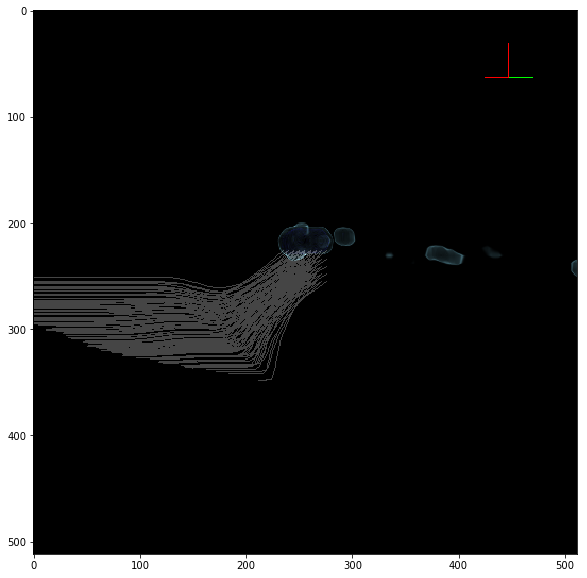

In [106]:
# tinterval = 180
# for interval in range(tinterval):
# normal_vector = [0., -np.sin(interval*2.*np.pi/tinterval), -np.cos(interval*2.*np.pi/tinterval)]
normal_vector = [0., -0.5, -0.5]
north_vector  = [1., 0., 0.]

# sc = yt.create_scene(hmm,field=('stream','dBZ'),lens_type='perspective')
sc = yt.create_scene(hmml,field=('stream','poss'),lens_type='perspective')
source = sc[0]

source.set_field('negs')
source.set_log(False)
bounds = (-3,3)

camera = sc.add_camera()
camera.set_focus(((8700.,'m'),(22000.,'m'),(38000.,'m')))
camera.switch_orientation(normal_vector=normal_vector,
                          north_vector=north_vector)

# Since this rendering is done in log space, the tranfer function needs
# to be specified in log space.
tf = yt.ColorTransferFunction(bounds)
sc.camera.width = (35000,'m')
# tf.add_layers(5, colormap=pyart.graph.cm.NWSVel)
tf.add_layers(4, 0.02, col_bounds=[-3, 3],
              alpha=np.ones(4, dtype='float64'), colormap=pyart.graph.cm.BuDRd18_r)
# tf.grey_opacity = True

source.tfh.tf = tf
# source.tfh.plot('tranfer_function.png',profile_field='dBZ')

# dens = VolumeSource(hmml,field='negs')
# sc.add_source(dens)

# add streamlines
c = hmm.domain_center
N = 100
scale = hmm.domain_width[2]
pos_dx = np.random.random((N,3))*scale-scale/2.
pos = c+pos_dx
sc.annotate_axes(alpha=2)

lines = LineSource(ttest[lselects],colors[lselects])
sc.add_source(lines)

# sc.save('rendering_{0:03d}.png'.format(interval),sigma_clip=0.5)
sc.save('rendering.png',sigma_clip=0.5)
plt.figure(figsize=(10,10))
img = mpimg.imread('rendering.png')
plt.imshow(img)

In [ ]:
# import yt
# from yt.visualization.volume_rendering.api import Scene, VolumeSource

# filePath = "Sedov_3d/sedov_hdf5_chk_0003"
# ds = yt.load(filePath)
# ds.periodicity = (True, True, True)

# sc = Scene()

# # set up camera
# cam = sc.add_camera(ds, lens_type='perspective')
# cam.resolution = [400, 400]

# cam.position = ds.arr([1, 1, 1], 'cm')
# cam.switch_orientation()

# # add rendering of density field
# dens = VolumeSource(ds, field='dens')
# dens.use_ghost_zones = True
# sc.add_source(dens)
# sc.save('density.png', sigma_clip=6)

# # add rendering of x-velocity field
# vel = VolumeSource(ds, field='velx')
# vel.use_ghost_zones = True
# sc.add_source(vel)
# sc.save('density_any_velocity.png', sigma_clip=6)

In [112]:
hmm.periodicity

(True, True, True)

### Read in h5 flash files

Just in case these become more important later

In [152]:
filename = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(dataf.time[:3])

sources = pd.read_hdf(filename,'events/LMA_120529_{0}000_600'.format(dataf.time[:3]))
flashes = pd.read_hdf(filename,'flashes/LMA_120529_{0}000_600'.format(dataf.time[:3]))

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    file2 = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(sfi.strftime('%H%M')[:3])
    sources2 = pd.read_hdf(file2,'events/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    flashes2 = pd.read_hdf(file2,'flashes/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    sources = pd.concat((sources,sources2))
    flashes = pd.concat((flashes,flashes2))

### Testing yt streamlines and basic plotting

yt : [INFO     ] 2017-10-31 17:03:20,727 xlim = 250.000000 60750.000000
yt : [INFO     ] 2017-10-31 17:03:20,728 ylim = 200.000000 17200.000000
yt : [INFO     ] 2017-10-31 17:03:20,730 xlim = 250.000000 60750.000000
yt : [INFO     ] 2017-10-31 17:03:20,731 ylim = 200.000000 17200.000000
yt : [INFO     ] 2017-10-31 17:03:20,732 Making a fixed resolution buffer of (('stream', 'dBZ')) 800 by 800



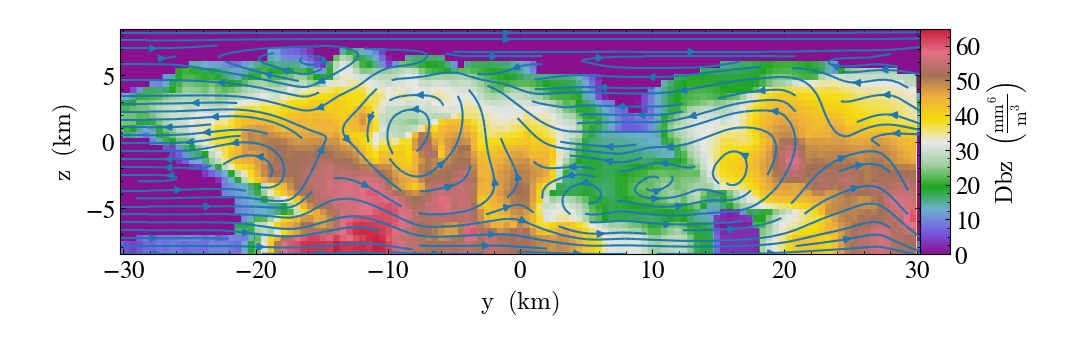

In [522]:
slc = yt.SlicePlot(hmm,'x',['dBZ'],
                   center=[8700,30500,50000])
slc.set_log('dBZ',False)
slc.set_cmap('dBZ',pyart.graph.cm.Carbone11)
slc.annotate_streamlines('v','w')
slc.show()

In [523]:
starts = np.array([5000,22000,30000]) + np.mgrid[0:10,0:3,0:3].reshape(3,-1).T*[500,1000,1000]

streamlines = Streamlines(hmm,starts,'w', 'v', 'u')
streamlines.integrate_through_volume()

yt : [INFO     ] 2017-10-31 17:04:01,587 AMRKDTree rebuilt, Final Volume: 9.307925e+13
Streamlining: 100%|██████████| 90/90 [00:00<00:00, 204.97it/s]


(20000, 50000)

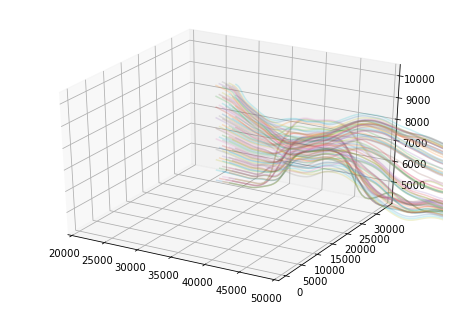

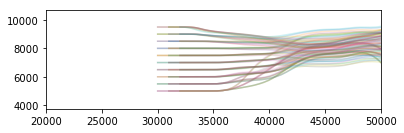

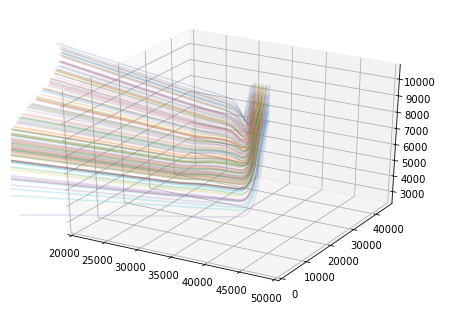

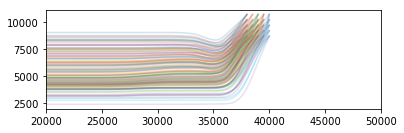

In [1091]:
fig=plt.figure()
ax = Axes3D(fig)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot3D(stream[:,2], stream[:,1], stream[:,0], alpha=0.2)
plt.xlim(20000,50000)

fig=plt.figure()
ax = fig.add_subplot(212)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot(stream[:,2], stream[:,0], alpha=0.2)
plt.xlim(20000,50000)

# DLA Comparison
fig=plt.figure()
ax = Axes3D(fig)
# for i in range(5):
for i in range(np.sum(selects)):
    ax.plot3D(np.array(tx.loc[selects])[i]*1e3, 
              np.array(ty.loc[selects])[i]*1e3, 
              np.array(tz.loc[selects])[i]*1e3, alpha=0.2) 
plt.xlim(20000,50000)

fig=plt.figure()
ax = fig.add_subplot(212)
# for i in range(5):
for i in range(np.sum(selects)):
    ax.plot(np.array(tx.loc[selects])[i]*1e3, 
#               np.array(ty.loc[selects])[i]*1e3, 
              np.array(tz.loc[selects])[i]*1e3, alpha=0.2) 
plt.xlim(20000,50000)

### Fiddling with flash grid files

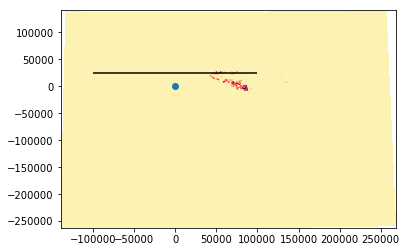

In [40]:
lev = 8
hlev = 571

# plt.contourf(glo[:,:,0],gla[:,:,0],flashgrid['lma_source'][8:10].sum(axis=(0,3)).T,30,cmap='magma_r')
# plt.contourf(flashgrid['longitude'],flashgrid['latitude'],flashgrid['lma_source'][8].sum(axis=2).T,20,cmap='magma_r')
plt.contourf(gnxs[:,:,lev],gnys[:,:,lev],flashgrid['lma_source'][8,:,:,lev].T,20,cmap='magma_r')
plt.hlines(gnys[hlev,0,0],-100000,100000)
plt.scatter(0,0)

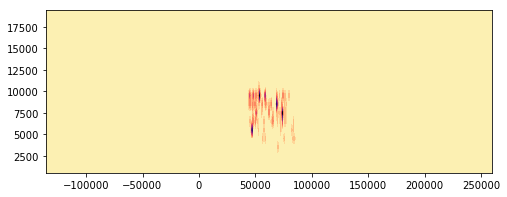

In [64]:
plt.figure(figsize=(8,3))
plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(flashgrid['lma_source'][8,:,hlev,:].T,20,cmap='magma_r')
# plt.xlim(50*dataf.dx,170*dataf.dx)
# plt.ylim(0,17500)

#### Other testing

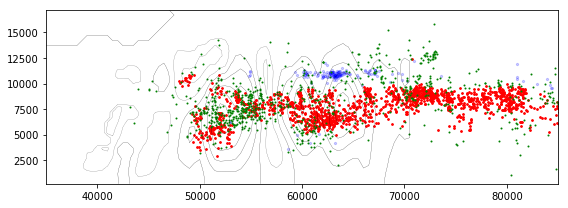

In [118]:
plt.figure(figsize=(8,3))

# gridcell = 60
depth    =  5

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)

c = 'b'
selection = (negs) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=5,alpha=0.2)
c = 'r'
selection = (poss) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=3)
c = 'g'
selection = (unas) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=1)

plt.xlim(70*dataf.dx,170*dataf.dx)
plt.tight_layout()

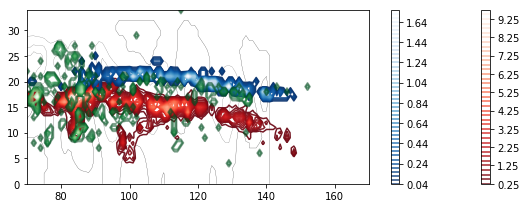

In [14]:
plt.figure(figsize=(8,3))

plt.contour(w[:,gridcell,:],colors='k',linewidths=0.2)

# plt.contour(np.ma.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T,colors='k',linewidths=0.1)
plt.contour(np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,40,cmap='Reds_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,50,cmap='Blues_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T,30,cmap='Greens_r', alpha=0.5)

plt.xlim(70,170)
plt.tight_layout()

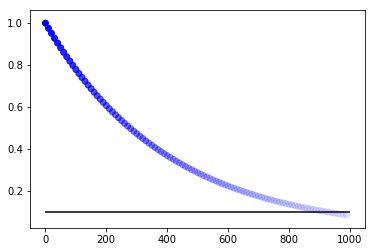

In [119]:
dist = np.arange(0.1,1000,10)
# alpha = 100./(dist)
alpha = np.exp(-dist/400.)
# alpha[alpha>1] = 1

c = np.asarray([(0,0,1,a) for a in alpha])
plt.scatter(dist,alpha,color=c,edgecolors=c)
plt.hlines(0.1,0,1000)

#### To be very specific about the trajectory from the DLA and make sure I understand how the output file is set up

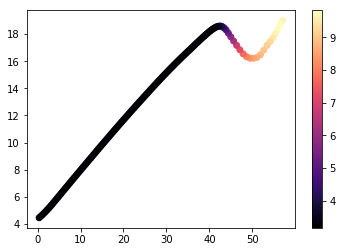

In [179]:
zt,yt,xt = 35,91,141 # total number of dimensions in each
xl,yl,zl = 57.,19.,9.7 # desired location (km) wrt radar origin
zg = (zl-0.2)/0.5 # location wrt traj subset grid
yg = (yl-5.0)/0.5
xg = (xl-15.)/0.5
gridloc = zg*yt*xt + yg*xt + xg # where it sits in the array
plt.scatter(tx.loc[gridloc],ty.loc[gridloc],c=tz.loc[gridloc],cmap='magma')
plt.colorbar()

In [125]:
p1 = np.array([4,3,1])
p2 = np.array([2,0,1])
# anglet = 0
anglet = -1*np.pi/4
n1 = p1*np.cos(anglet) - p2*np.sin(anglet)
n2 = p1*np.sin(anglet) + p2*np.cos(anglet)

In [142]:
np.arctan(-0./2) * 180/np.pi

-0.0

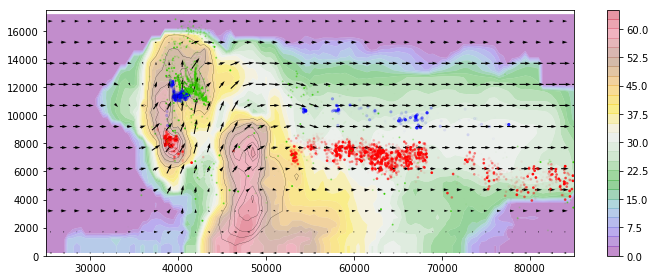

In [144]:
plt.figure(figsize=(10,4))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)
rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0)) # Just the closest cross section from flashgrid to the radar grid

plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],30,cmap=pyart.graph.cm.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
           scale=1500,width=0.002,pivot='middle',
          )

# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],np.mean(flashgrid['flash_footprint'][8,:,lgrid-1:lgrid+2,:],axis=1),
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.2)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

# plt.scatter(tx.loc[selects]*1e3,tz.loc[selects]*1e3,
#             c=np.zeros_like(tx.loc[selects])+np.arange(151),s=0.2,cmap='magma',alpha=0.5)
# #             c=np.abs(ty.loc[selects]*1e3-mfrom0),s=0.2,cmap='magma')

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()


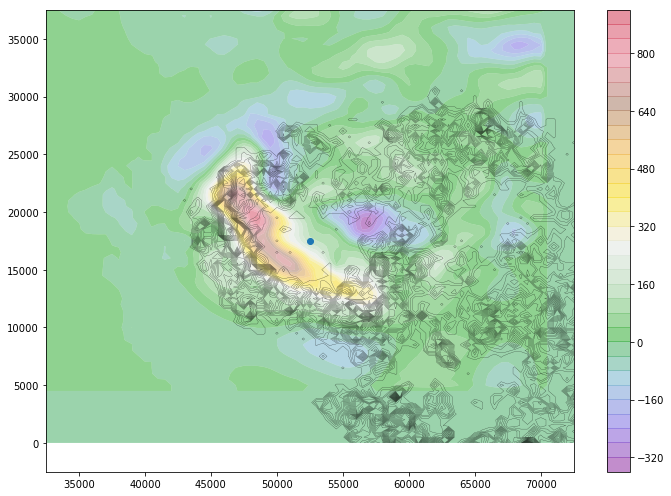

In [208]:
#########################################
plt.figure(figsize=(10,7))
level = 9.2

dist = np.abs(nzs-level*1e3)
alpha = np.exp(-dist/400.)
rgrid = int((level-0.2)*1e3/dataf.dy)
# lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

plt.contourf(rx[rgrid,:,:],ry[rgrid,:,:],np.sum(w,axis=0),40,cmap=pyart.graph.cm.Carbone11,alpha=0.5,antialiased=True)
plt.colorbar()
# plt.contour(rx[rgrid,:,:],ry[rgrid,:,:],DLA[7,rgrid,:,:],colors='k',linewidths=0.2)
plt.contour(rx[rgrid,:,:],ry[rgrid,:,:],np.sum(p_counts,axis=2).T,30,colors='k',linewidths=0.2)

# step=3
# plt.quiver(rx[rgrid,::step,::step],ry[rgrid,::step,::step],
#             u[rgrid,::step,::step], v[rgrid,::step,::step],
#            scale=1500,width=0.002,pivot='middle',
#           )

# Note the flashgrid is 0.2 km off
# plt.contour(gnxs[:,:,rgrid//2],gnys[:,:,rgrid//2],np.mean(flashgrid['flash_footprint'][8,:,:,rgrid//2-1:rgrid//2+2],axis=2).T,
#             levels=np.arange(5,1500,50),colors='purple',linewidths=0.5)
# plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)

# c = np.asarray([(0,0,1,a) for a in alpha])[negs]
# plt.scatter(nxs[negs],nys[negs],color=c,edgecolors=c,s=5)
# c = np.asarray([(1,0,0,a) for a in alpha])[poss]
# plt.scatter(nxs[poss],nys[poss],color=c,edgecolors=c,s=3)
# c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
# plt.scatter(nxs[unas],nys[unas],color=c,edgecolors=c,s=1)

i,j = np.unravel_index(np.argmax(np.sum(w[:],axis=0)), np.sum(w,axis=0).shape)
plt.scatter(j*500+4000,i*500-2000)

plt.xlim(j*500+4000-20000,j*500+4000+20000)
plt.ylim(i*500-2000-20000,i*500-2000+20000)
plt.tight_layout()

In [228]:
# Angle from N
anglet = 1*np.pi/4 # To keep w left, limit to within -pi/2, pi/2
n1 = (nxs-(j*500+4000))*np.cos(anglet) - (nys-(i*500-2000))*np.sin(anglet)
n2 = (nxs-(j*500+4000))*np.sin(anglet) + (nys-(i*500-2000))*np.cos(anglet)

(-30000, 30000)

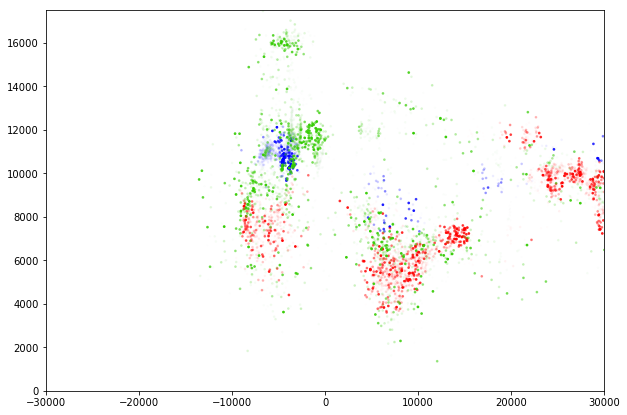

In [229]:
fig = plt.figure(figsize=(10,7))
alpha = np.exp(-np.abs(n2)/400.)

c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(n1[negs],nzs[negs],color=c,edgecolors=c,s=3)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(n1[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(n1[unas],nzs[unas],color=c,edgecolors=c,s=3)

plt.ylim(0,17500)
plt.xlim(-30000,30000)

In [233]:
from scipy import interpolate

In [239]:
cx = j*500+4000
cy = i*500-2000

In [263]:
minx = cx - 15000*np.cos(anglet)
maxx = cx + 15500*np.cos(anglet)
miny = cy + 15000*np.sin(anglet)
maxy = cy - 15500*np.sin(anglet)

grid_x, grid_y, grid_z = np.meshgrid(np.linspace(minx,maxx,61),np.linspace(miny,maxy,61),rz[:,0,0])

if miny < maxy:    
    subset = (rx > (minx-500)) & (rx < (maxx+500)) & (ry > (miny-500)) & (ry < (maxy+500))
if miny > maxy:
    subset = (rx > (minx-500)) & (rx < (maxx+500)) & (ry < (miny+500)) & (ry > (maxy-500))

In [281]:
# interpolate.griddata((rx[subset].flatten(),ry[subset].flatten(),rz[subset].flatten()),
#                       w[subset].flatten(), (grid_x,grid_y,grid_z),method='linear')

In [280]:
from scipy import spatial